<a href="https://colab.research.google.com/github/ThisIsJorgeLima/DS-Unit-2-Kaggle-Challenge/blob/master/module1/JAL_Dec_9__assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [x] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition.
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [x] Begin with baselines for classification.
- [x] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [x] Get your validation accuracy score.
- [x] Get and plot your feature importances.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [44]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
# If you're working locally:
#else:
    #DATA_PATH = '../data/'
    

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
# Pandas Profiling can be very slow with medium & large datasets.
# These parameters will make it faster.
# https://github.com/pandas-profiling/pandas-profiling/issues/222

import pandas_profiling

profile_report = train.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report

In [48]:
# Lets split train into train, validation data sets: 

train, val = train_test_split(train, test_size = 0.8, train_size = 0.2, 
                              random_state = 42, stratify=train['status_group'])

train.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
36369,12516,0.0,2011-02-23,Legeza Legeza,70,Private,38.714599,-6.919704,Legeza,0,Wami / Ruvu,Mzenga B,Pwani,6,3,Kisarawe,Vihingo,500,True,GeoData Consultants Ltd,Private operator,NaN,True,2004,india mark iii,india mark iii,handpump,private operator,commercial,never pay,never pay,salty,salty,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
12756,59778,0.0,2011-07-20,Hifab,0,Hesawa,33.390971,-3.044316,Majilala,0,Lake Victoria,Mwajilala,Mwanza,19,4,Kwimba,Lyoma,0,NaN,GeoData Consultants Ltd,VWC,NaN,True,0,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional


In [47]:
train.tail(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
59399,26348,0.0,2011-03-23,World Bank,191,World,38.104048,-6.747464,Kwa Mzee Lugawa,0,Wami / Ruvu,Kikatanyemba,Morogoro,5,2,Morogoro Rural,Ngerengere,150,True,GeoData Consultants Ltd,VWC,NaN,True,2002,nira/tanira,nira/tanira,handpump,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [49]:
train['status_group'].value_counts(normalize=True)

functional                 0.543098
non functional             0.384259
functional needs repair    0.072643
Name: status_group, dtype: float64

In [69]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
recorded_by,11880,1,GeoData Consultants Ltd,11880
public_meeting,11248,2,True,10228
permit,11253,2,True,7796
status_group,11880,3,functional,6452
source_class,11880,3,groundwater,9206
quantity_group,11880,5,enough,6724
quantity,11880,5,enough,6724
management_group,11880,5,user-group,10550
waterpoint_type_group,11880,5,communal standpipe,6809
quality_group,11880,6,good,10104


In [112]:
# Lets look at lat and long for potential outliers:
train[['longitude', 'latitude']].describe()

,longitude,latitude
count,11880.000000,1.188000e+04
mean,34.068276,-5.666282e+00
std,6.568122,2.918298e+00
min,0.000000,-1.158630e+01
25%,33.081763,-8.390979e+00
50%,34.904443,-4.973731e+00
75%,37.160569,-3.320768e+00
max,40.344301,-2.000000e-08


In [0]:
import numpy as np

def wrangle(X):
  '''Wrangle train, validate, and test sets in the same way'''

# Prevent SettingWithCopyWarning
  X = X.copy()

  X['latitude']=X['latitude'].replace(-2e-08,0)

# Lets replace the zeros with NaNs, and impute missing values later.
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
    x = X.drop(columns ='quantity_group')

    # return wrangled dataframe
    return X

    train = wrangle(train)
    val = wrangle(val)
    test = wrangle(test)

Select features:

In [114]:
# The status_group column is our target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target,'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get our series with cardinality of nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get our categorical features with a cardinaity <=50
categorical_features = cardinality[cardinality<=50].index.tolist()

# Lets combine the lists
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# Lets arrange data into X features matrix and y target vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test [features]

In [116]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()
model = LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)
model.fit(X_train_scaled, y_train)

X_val_encoded = encoder.transform(X_val)
X_val_imputed = imputer.transform(X_val_encoded)
X_val_scaled = scaler.transform(X_val_imputed)
print('The Validation Accuracy is:', model.score(X_val_scaled, y_val))

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)

The Validation Accuracy is: 0.7347222222222223


In [117]:
from sklearn.tree import DecisionTreeClassifier

Pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                         SimpleImputer(strategy='mean'),
                         DecisionTreeClassifier(random_state=42)
                         )

# Fit on train
pipeline.fit(X_train, y_train)

# Score on train, val
print('Train Accuracy', pipeline.score(X_train,y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Train Accuracy 0.8673400673400673
Validation Accuracy 0.735206228956229


In [0]:
# Plot tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
#import graphviz
#from sklearn.tree import export_graphviz

#model = pipeline.named_steps['decisiontreeclassifier']
#encoder = pipeline.named_steps['onehotencoder']
#encoded_columns = encoder.transform(X_val).columns

#dot_data = export_graphviz(model, 
                           #out_file=None, 
                           #max_depth=3, 
                           #feature_names=encoded_columns,
                           #class_names=model.classes_, 
                           #impurity=False, 
                           #filled=True, 
                           #proportion=True, 
                           #rounded=True)   
#display(graphviz.Source(dot_data))

In [0]:
# Increase "minimum node size" / min_samples_leaf, to reduce model complexity,
# Remeber this happens to improve validation accuracy here.

#pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                         #SimpleImputer(strategy='mean'),
                         #DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
                         #)
#pipeline.fit(X_train, y_train)
#print('The Train Accuracy is:', pipeline.score(X_train, y_train))
#print('The Validation Accuracy is', pipeline.score (X_val, y_val))


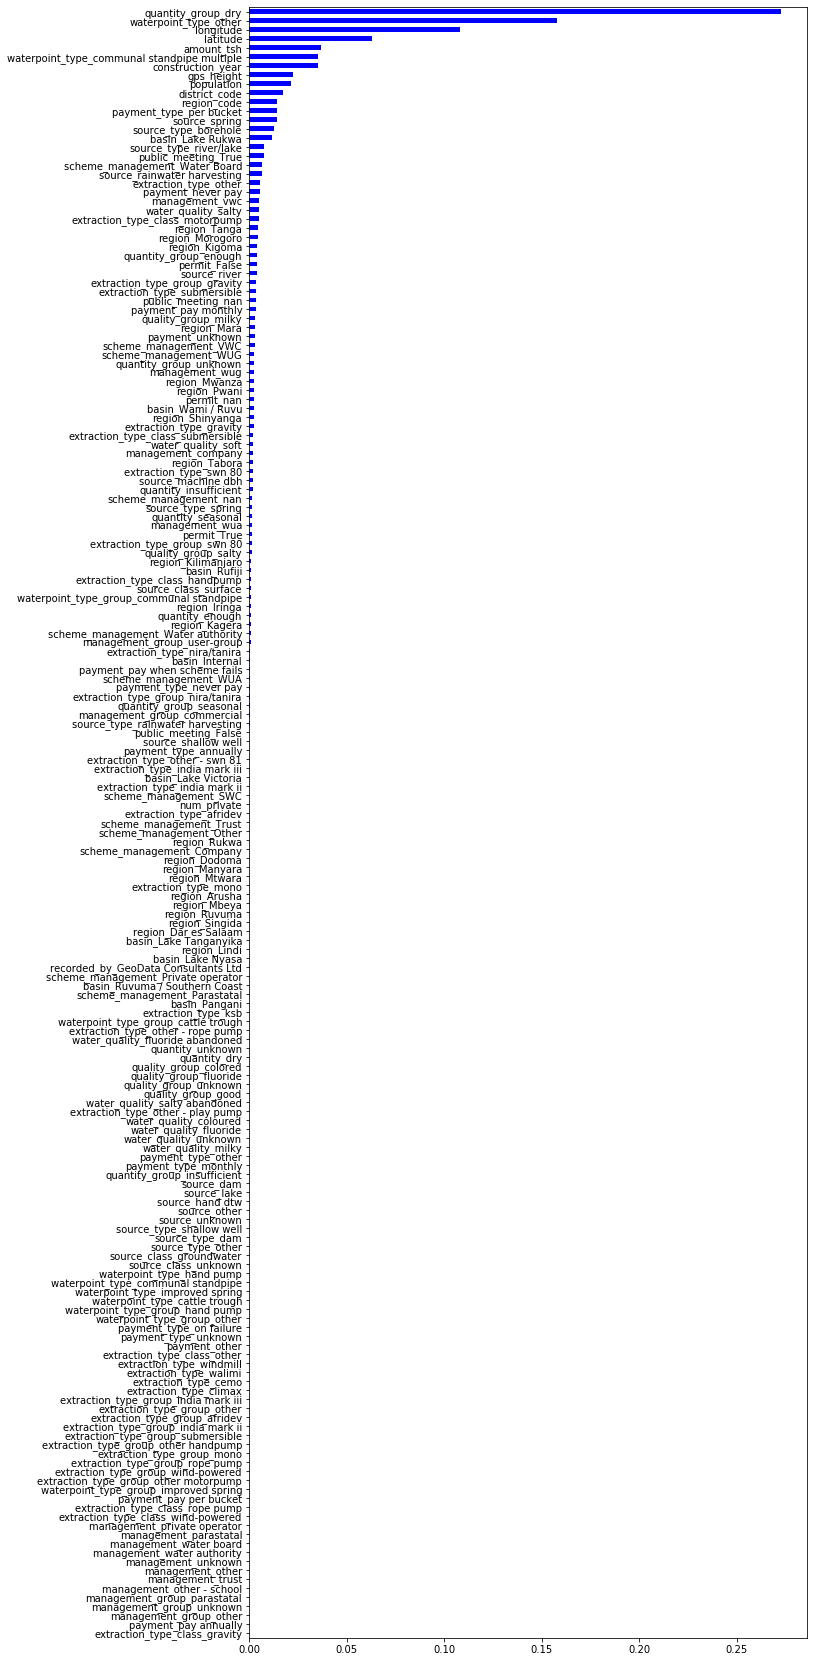

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['decisiontreeclassifier']

# Linear models have coefficients,
# but trees have "feature importances"

encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='blue')
plt.show()

In [0]:
my_submission = sample_submission.copy()
my_submission['status_group'] = y_pred
my_submission.to_csv('JAL_Dec_9_Kaggle_Challenge_1.csv', index=False)

from google.colab import files
files.download('JAL_Dec_9_Kaggle_Challenge_1.csv')